# This Notebook is Model Testing for Class instances of Classification Codes

In [1]:
# Import all necessary packages

import ast
import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt

from prettytable import PrettyTable

2023-07-27 12:13:52.360141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# All Data

The subsequent section will test the performance of the following models on the whole dataset:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks


In [3]:
# Load the data
df = pd.read_csv('Data_Preprocessed_Class.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06]
1,imag sens devic imag sens devic includ substra...,[H01]
2,antigen specif immunotherapi covid19 fusion pr...,"[A61, C07, C12]"
3,secur deescal data access concept technolog di...,[G06]
4,system method secur cloudbas physiolog data pr...,"[A61, G16, G06]"


In [4]:
# As most multi-label classifiers requres each class to have multiple instances.
# All codes which appear less than 5 times will be removed

for i in range(10):

    # Determine the codes to be removed
    unique_codes = df['Classification Codes'].explode().value_counts()
    codes_to_remove = unique_codes[unique_codes < 5 ].index.tolist()

    # Remove rows with empty 'Classification Codes' column
    df = df.dropna(subset=['Classification Codes'])

    # Remove codes in the list codes_to_remove
    df['CodeCount'] = df['Classification Codes'].apply(lambda codes: sum(code in codes_to_remove for code in codes))
    df = df[df['CodeCount'] == 0].drop(columns=['CodeCount'])

In [5]:
# Now all codes will have a minimum of 5 instances
print(unique_codes)

A61    9163
G06    5267
H04    3697
G16    2111
G01    1594
       ... 
F17       6
D03       5
C22       5
A44       5
D01       5
Name: Classification Codes, Length: 69, dtype: int64


In [6]:
# Encode "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [7]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [8]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.45472
Hamming Loss: 0.013954782608695652


## Random Forest Classifier 


In [9]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.51424
Hamming Loss: 0.012674782608695652


## Support Vector Machine  (One vs Rest)


In [8]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.39392
Hamming Loss: 0.016422028985507247


## Deep Neural Networks 

In [9]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build basic deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

2023-07-27 12:29:11.210397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
313/313 [==============================] - 12s 35ms/step - loss: 0.0866 - accuracy: 0.6710 - val_loss: 0.0439 - val_accuracy: 0.7844
Epoch 2/10
313/313 [==============================] - 8s 26ms/step - loss: 0.0297 - accuracy: 0.7888 - val_loss: 0.0419 - val_accuracy: 0.7620
Epoch 3/10
313/313 [==============================] - 9s 27ms/step - loss: 0.0195 - accuracy: 0.7946 - val_loss: 0.0434 - val_accuracy: 0.7644
Epoch 4/10
313/313 [==============================] - 9s 30ms/step - loss: 0.0134 - accuracy: 0.8001 - val_loss: 0.0487 - val_accuracy: 0.7612
Epoch 5/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0096 - accuracy: 0.7992 - val_loss: 0.0528 - val_accuracy: 0.7524
Epoch 6/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0069 - accuracy: 0.8046 - val_loss: 0.0599 - val_accuracy: 0.7504
Epoch 7/10
313/313 [==============================] - 9s 27ms/step - loss: 0.0050 - accuracy: 0.7992 - val_loss: 0.0652 - val_accuracy: 0.743

In [10]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.6710, Validation Accuracy: 0.7844
Epoch 2 - Accuracy: 0.7888, Validation Accuracy: 0.7620
Epoch 3 - Accuracy: 0.7946, Validation Accuracy: 0.7644
Epoch 4 - Accuracy: 0.8001, Validation Accuracy: 0.7612
Epoch 5 - Accuracy: 0.7992, Validation Accuracy: 0.7524
Epoch 6 - Accuracy: 0.8046, Validation Accuracy: 0.7504
Epoch 7 - Accuracy: 0.7992, Validation Accuracy: 0.7432
Epoch 8 - Accuracy: 0.8008, Validation Accuracy: 0.7448
Epoch 9 - Accuracy: 0.7910, Validation Accuracy: 0.7500
Epoch 10 - Accuracy: 0.8013, Validation Accuracy: 0.7548

Hamming Loss: 0.012855652173913044


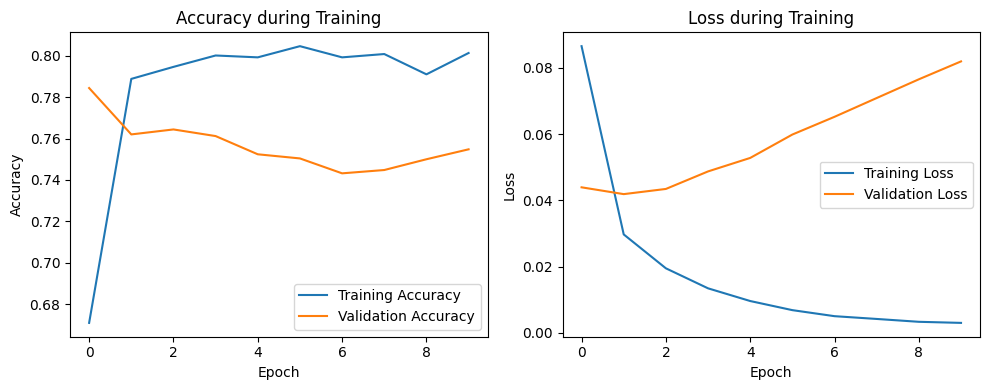

In [11]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Top 18 Codes

The subsequent section will utalise a subset of the whole data. This subset only contains the set of top 18 codes by frequency these codes are (removed repeated codes):

- A61   
- G06  
- G16
- H04


The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [12]:
# Load the data for top 18 codes
df = pd.read_csv('Data_Preprocessed_Class_Top18.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06]
1,antigen specif immunotherapi covid19 fusion pr...,[A61]
2,secur deescal data access concept technolog di...,[G06]
3,system method secur cloudbas physiolog data pr...,"[A61, G16, G06]"
4,collim detector base medic imag system medic i...,[A61]


In [13]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [14]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##  Logistic Regression

In [15]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.6414041994750657
Hamming Loss: 0.12212926509186352


## Random Forest 

In [16]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.7001312335958005
Hamming Loss: 0.10621719160104987


## Support Vector Machine  (One vs Rest)


In [17]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.6122047244094488
Hamming Loss: 0.13574475065616798


## Deep Neural Networks 

In [18]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
305/305 [==============================] - 12s 38ms/step - loss: 0.2745 - accuracy: 0.8325 - val_loss: 0.2353 - val_accuracy: 0.8470
Epoch 2/10
305/305 [==============================] - 9s 31ms/step - loss: 0.1401 - accuracy: 0.8637 - val_loss: 0.2631 - val_accuracy: 0.8589
Epoch 3/10
305/305 [==============================] - 9s 31ms/step - loss: 0.0735 - accuracy: 0.8675 - val_loss: 0.2918 - val_accuracy: 0.8519
Epoch 4/10
305/305 [==============================] - 9s 30ms/step - loss: 0.0393 - accuracy: 0.8697 - val_loss: 0.3521 - val_accuracy: 0.8228
Epoch 5/10
305/305 [==============================] - 8s 25ms/step - loss: 0.0213 - accuracy: 0.8673 - val_loss: 0.4208 - val_accuracy: 0.8409
Epoch 6/10
305/305 [==============================] - 8s 27ms/step - loss: 0.0123 - accuracy: 0.8721 - val_loss: 0.4753 - val_accuracy: 0.8400
Epoch 7/10
305/305 [==============================] - 7s 24ms/step - loss: 0.0100 - accuracy: 0.8709 - val_loss: 0.4932 - val_accuracy: 0.826

In [19]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.8325, Validation Accuracy: 0.8470
Epoch 2 - Accuracy: 0.8637, Validation Accuracy: 0.8589
Epoch 3 - Accuracy: 0.8675, Validation Accuracy: 0.8519
Epoch 4 - Accuracy: 0.8697, Validation Accuracy: 0.8228
Epoch 5 - Accuracy: 0.8673, Validation Accuracy: 0.8409
Epoch 6 - Accuracy: 0.8721, Validation Accuracy: 0.8400
Epoch 7 - Accuracy: 0.8709, Validation Accuracy: 0.8261
Epoch 8 - Accuracy: 0.8635, Validation Accuracy: 0.8486
Epoch 9 - Accuracy: 0.8663, Validation Accuracy: 0.8413
Epoch 10 - Accuracy: 0.8712, Validation Accuracy: 0.8437

Hamming Loss: 0.0978510498687664


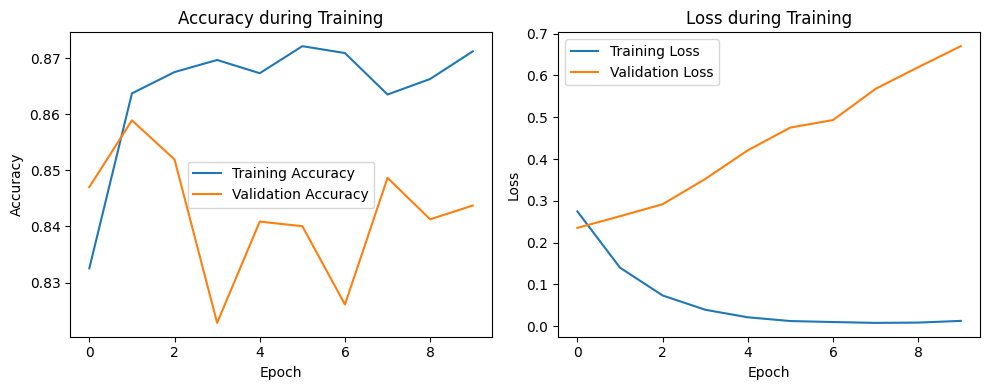

In [20]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Selected 7 Codes

The subsequent section will utalise a smaller subset of the whole data. This subset only contains the set of selected 7 codes by Beyond Blood, these codes are (removed repeated codes):

- A61      
- G06
- G16

The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [21]:
# Load the data for selected 7 codes by Beyond Blood
df = pd.read_csv('Data_Preprocessed_Class_Selected7.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06]
1,antigen specif immunotherapi covid19 fusion pr...,[A61]
2,secur deescal data access concept technolog di...,[G06]
3,system method secur cloudbas physiolog data pr...,"[A61, G16, G06]"
4,collim detector base medic imag system medic i...,[A61]


In [22]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [23]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [24]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.7092065868263473
Hamming Loss: 0.12437624750499002


## Random Forest 

In [25]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.7559880239520959
Hamming Loss: 0.11202594810379242


## Support Vector Machine  (One vs Rest)


In [26]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.6833832335329342
Hamming Loss: 0.1379740518962076


## Deep Neural Networks

In [27]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build the deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
268/268 [==============================] - 11s 40ms/step - loss: 0.2854 - accuracy: 0.8664 - val_loss: 0.2546 - val_accuracy: 0.8676
Epoch 2/10
268/268 [==============================] - 7s 27ms/step - loss: 0.1408 - accuracy: 0.8997 - val_loss: 0.2846 - val_accuracy: 0.8760
Epoch 3/10
268/268 [==============================] - 7s 27ms/step - loss: 0.0717 - accuracy: 0.9018 - val_loss: 0.3567 - val_accuracy: 0.8755
Epoch 4/10
268/268 [==============================] - 7s 26ms/step - loss: 0.0343 - accuracy: 0.9063 - val_loss: 0.4490 - val_accuracy: 0.8807
Epoch 5/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0183 - accuracy: 0.9082 - val_loss: 0.5195 - val_accuracy: 0.8601
Epoch 6/10
268/268 [==============================] - 6s 24ms/step - loss: 0.0102 - accuracy: 0.9112 - val_loss: 0.5906 - val_accuracy: 0.8559
Epoch 7/10
268/268 [==============================] - 8s 28ms/step - loss: 0.0101 - accuracy: 0.9113 - val_loss: 0.6622 - val_accuracy: 0.867

In [28]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.8664, Validation Accuracy: 0.8676
Epoch 2 - Accuracy: 0.8997, Validation Accuracy: 0.8760
Epoch 3 - Accuracy: 0.9018, Validation Accuracy: 0.8755
Epoch 4 - Accuracy: 0.9063, Validation Accuracy: 0.8807
Epoch 5 - Accuracy: 0.9082, Validation Accuracy: 0.8601
Epoch 6 - Accuracy: 0.9112, Validation Accuracy: 0.8559
Epoch 7 - Accuracy: 0.9113, Validation Accuracy: 0.8676
Epoch 8 - Accuracy: 0.9080, Validation Accuracy: 0.8629
Epoch 9 - Accuracy: 0.9121, Validation Accuracy: 0.8666
Epoch 10 - Accuracy: 0.9089, Validation Accuracy: 0.8620

Hamming Loss: 0.10117265469061876


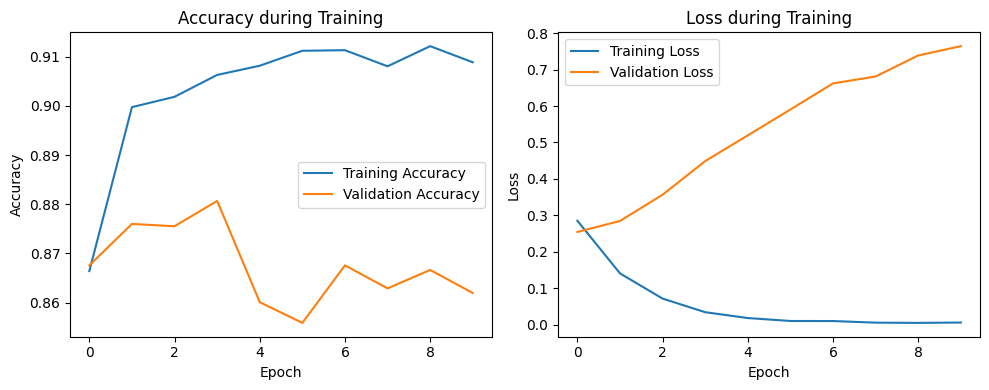

In [29]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Results
This section presents all results from the model into a table format for ease of visualisation

In [30]:
def results_table(data):
    table = PrettyTable()
    
    # Define column headers
    table.field_names = ["Model", "Accuracy", "Hamming Loss"]
    
    # Add data
    for row in data:
        table.add_row(row)
        
    # Align data
    table.align["Model"] = "l"
    table.align["Accuracy"] = "r"
    table.align["Hamming Loss"] = "r"
    table.float_format = ".4"

    print(table)

In [31]:
# Data for the table
data_all = [
    ["Logistic Regression", 0.4547, 0.0140],
    ["Random Forest", 0.5142, 0.0127],
    ["Support Vector Machine", 0.3939, 0.0164],
    ["Deep Neural Networks", 0.7644, 0.0129]
]

data_top18 = [
    ["Logistic Regression", 0.6414, 0.1221],
    ["Random Forest", 0.7001, 0.1062],
    ["Support Vector Machine", 0.6122, 0.1357],
    ["Deep Neural Networks", 0.8589, 0.0979]
]

data_selected7 = [
    ["Logistic Regression", 0.7092, 0.1244],
    ["Random Forest", 0.7560, 0.1120],
    ["Support Vector Machine", 0.6834, 0.1380],
    ["Deep Neural Networks", 0.8807, 0.1012]
]

print("\t\t       \033[1mAll Data\033[0m")
results_table(data_all)

print("\n\n\t\t        \033[1mTop 18\033[0m")
results_table(data_top18)

print("\n\n\t\t       \033[1mSelected 7\033[0m")
results_table(data_selected7)

		       All Data
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.4547 |       0.0140 |
| Random Forest          |   0.5142 |       0.0127 |
| Support Vector Machine |   0.3939 |       0.0164 |
| Deep Neural Networks   |   0.7644 |       0.0129 |
+------------------------+----------+--------------+


		        Top 18
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.6414 |       0.1221 |
| Random Forest          |   0.7001 |       0.1062 |
| Support Vector Machine |   0.6122 |       0.1357 |
| Deep Neural Networks   |   0.8589 |       0.0979 |
+------------------------+----------+--------------+


		       Selected 7
+------------------------+----------+--------------+
| Model                  | Accuracy | Ha